# 0927실습

jax소개

jax문법 코드 구현 조금 해보기

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

#기타 필요한 모듈과 설정
from functools import partial
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png2x')
plt.rcParams.update({"figure.constrained_layout.use":True})

gpu하면 쿠다가 나와야한다

In [ ]:
jax.devices()

[CudaDevice(id=0)]

In [ ]:
def my_function(x):
  return x+x**2+x**3

In [ ]:
# Python number
my_function(5)

155

In [ ]:
[my_function(x) for x in range(10)]

[0, 3, 14, 39, 84, 155, 258, 399, 584, 819]

In [ ]:
# JAX array
x=jnp.arange(10)
my_function(x)

Array([  0,   3,  14,  39,  84, 155, 258, 399, 584, 819], dtype=int32)

In [ ]:
jnp.array([1,2,3]).dtype

dtype('int32')

In [ ]:
x=np.arange(4)
x[2]=999
x

array([  0,   1, 999,   3])

In [ ]:
x=jnp.arange(4)
new_x=x.at[2].set(999)
print(f"{x=}")
print(f"{new_x=}")

x=Array([0, 1, 2, 3], dtype=int32)
new_x=Array([  0,   1, 999,   3], dtype=int32)


In [ ]:
rng =np.random.default_rng(78)
x=rng.standard_normal(10)
x

array([-0.67654859,  0.39557053, -0.38162325, -1.09390517,  0.70997843,
       -0.34345434,  0.04641205,  0.72250144,  2.53012991, -0.48035193])

In [ ]:
%time  np.mean(x)

CPU times: user 107 µs, sys: 20 µs, total: 127 µs
Wall time: 132 µs


0.14287090723100673

In [ ]:
%time jnp.mean(x)

CPU times: user 30.3 ms, sys: 953 µs, total: 31.2 ms
Wall time: 47.8 ms


Array(0.1428709, dtype=float32)

In [ ]:
# JIT
my_function=jax.jit(my_function)

In [ ]:
my_function(5)

Array(155, dtype=int32, weak_type=True)

아래해보기

In [ ]:
x_np = np.linspace(0,1,num=50_000_000, dtype=np.float32)
x_jnp=jnp.arange(x_np)

ValueError: jax.numpy.arange: arguments must be scalars; got stop=[0.0000000e+00 2.0000000e-08 4.0000000e-08 ... 9.9999994e-01 1.0000000e+00
 1.0000000e+00]

In [ ]:
f_jitted=jax.jit(x_jnp)

NameError: name 'x_jnp' is not defined

나중에

In [ ]:
import torch
N=100
t=torch.linspace(0,10,N).view(-1,1)
t_init=torch.zeros([1,1])
y_init=torch.FloatTensor([[0,1]])
y_true=torch.cat([torch.sin(t),torch.cos(t)],dim=1)

In [ ]:
class model (nn.model)

# 1004실습

In [23]:
from collections.abc import Callable, Sequence
from functools import partial

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import optax
import scipy as sp
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.rcParams.update({"figure.constrained_layout.use": True})

In [24]:
class ManualMLP:
    def __init__(self, features, activation=jnp.tanh):
        self.features = features  # 각 은닉층과 출력의 크기(입력 크기 제외)
        self.activation = activation  # 활성화 함수

    def init(self, key, x):
        # 보통 난수를 사용해야 하는 함수는 첫 번째 인자로 키를 받음
        # 입력 차원은 더미 x(모양만 필요)를 받아서 확정
        layer_keys = jax.random.split(key, len(self.features))

        features = (x.shape[-1],) + tuple(self.features)
        params = {"params": {}} # params라는 dictionary에 다 저장해넣음
        for i, (layer_key, in_features, out_features) in enumerate(
            zip(layer_keys, features, features[1:])
        ):
            params["params"][f"Dense_{i}"] = {
                "bias": jnp.zeros(out_features),
                "kernel": (
                    jnp.sqrt(1 / in_features)
                    * jax.random.normal(
                        layer_key, shape=(in_features, out_features)
                    )
                ),  # LeCun normal initialization
            }
        return params

    def apply(self, params, x):
        # 파라미터를 객체(인스턴스)에 저장해 두는 것이 아니라
        # 함수를 부를 때 x와 함께 같이 넘겨 주어 계산.
        # 사용자가 오용해서 `self.features`와 `self.activation`을
        # 억지로 바꾸지 않는 한 JIT 컴파일에 포함되어도 문제는 없음
        for i in range(len(self.features)):
            dense_params = params["params"][f"Dense_{i}"]
            x = dense_params["bias"] + x @ dense_params["kernel"]
            if i < len(self.features) - 1:
                x = self.activation(x)
        return x

In [25]:
model = ManualMLP((5, 1))
# => 입력 크기 ? -> 은닉층 크기 5 -> 출력 크기 1

key = jax.random.key(78)
params = model.init(key, jnp.zeros((2,)))
# 크기가 (2,)인 입력 -> 입력 크기 2로 확정하여 파라미터를 만듦
# 크기만 중요하고 값은 아무 상관 없음

params

{'params': {'Dense_0': {'bias': Array([0., 0., 0., 0., 0.], dtype=float32),
   'kernel': Array([[-1.3550441 ,  0.66525805, -0.35675827, -0.90526015, -0.2415924 ],
          [ 0.40787628, -0.00753416, -0.07203963,  0.35522676, -0.60577434]],      dtype=float32)},
  'Dense_1': {'bias': Array([0.], dtype=float32),
   'kernel': Array([[ 0.0194957 ],
          [-0.19525081],
          [ 0.1380145 ],
          [-0.1751945 ],
          [ 0.09800039]], dtype=float32)}}}

In [26]:
jax.tree.map(lambda x: x.shape, params)

{'params': {'Dense_0': {'bias': (5,), 'kernel': (2, 5)},
  'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}

In [27]:
x = jnp.array([1.5, 2.5])

y_pred = model.apply(params, x)  # 실제 모델 계산
y_pred

Array([-0.26341045], dtype=float32)

In [28]:
# 문제와 모델 설정
domain = (0.0, 1.0)
eps = 1e-4

mlp = ManualMLP((20, 20, 20, 1))

# 함수 모양(params 제외하고) () -> ()
# 즉, 입력 스칼라 -> 출력 스칼라
def boundary_layer_u(params, x): #여기가 u_theta 정의하는곳
    return x * (1 - x) * mlp.apply(params, jnp.array([x])).reshape()
#PyTorch 에서는 mlp(params,x) 뭐 이런식으로 바로 넣으면 되는데, jax에서는 apply를 항상 써줘야해요
# () -> () 는 x를 scalar로 받아옴
def boundary_layer_pde(params, x): # x를 하나 받아오는것이기 때문에 forward를 받아와도 상관없어요
    u_x = jax.jacfwd(boundary_layer_u, argnums=1)
    u_xx = jax.jacfwd(u_x, argnums=1)
# 2번 미분 하는거면 forward 한 번 쓰고, backward 한 번 써보는게 좋아요.
    return -eps * u_xx(params, x) - u_x(params, x) - 1
# (N,) -> (N,) 는 x를 vector로 받아옴
# `params`는 병렬처리하지 않고(None) `x`만 첫 번째 배치 차원(0)을 병렬 처리
batched_boundary_layer_pde = jax.vmap(boundary_layer_pde, in_axes=(None, 0))
# (None, 0)은 첫번째는 parameters에 해당하는 것이고, parameter는 건들지 말고
# x만 하나하나 계산 하라는뜻
# (N,) -> ()
def boundary_layer_loss(params, x):
    return (batched_boundary_layer_pde(params, x) ** 2).mean()

In [29]:
# 훈련 설정
key = jax.random.key(78)
n_epochs = 80_000
n_x_samples = 300
learning_rate = optax.cosine_decay_schedule(3e-4, decay_steps=n_epochs)
optimizer = optax.adam(learning_rate) # optimizer를 adam으로 설정

params = mlp.init(key, jnp.zeros((1,)))
optimizer_state = optimizer.init(params)
# 최근에 나온 좋은 optimizer는 momentum도 보는것이 있어서, 우리가 3가지를 들고 다닐거에요
# 파라미터 업데이트를 할 때
#     params = jax.tree.map(
#         lambda param, grad: param - learning_rate * grad, params, grads
#     )
# 처럼 직접 하는 대신, Optax의 optimizer를 이용
@jax.jit
def step(params, optimizer_state, x):
    loss, grads = jax.value_and_grad(boundary_layer_loss)(params, x)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    # parameter를 optimizer에게 주고 새로운 parameter, 새로운 optimizer state를 받아온다.
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [30]:
x_samples = jnp.linspace(*domain, n_x_samples)

loss_history = []
for i in tqdm(range(1, n_epochs + 1)):
    params, optimizer_state, loss_value = step(
        params, optimizer_state, x_samples
    )

    loss_history.append(loss_value.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4000: loss_value = 0.999865
Epoch 8000: loss_value = 0.999775
Epoch 12000: loss_value = 0.999049
Epoch 16000: loss_value = 0.990576
Epoch 20000: loss_value = 0.49701
Epoch 24000: loss_value = 0.255095
Epoch 28000: loss_value = 0.0648302
Epoch 32000: loss_value = 0.00488888
Epoch 36000: loss_value = 0.00136271
Epoch 40000: loss_value = 8.12178e-05
Epoch 44000: loss_value = 5.26098e-05
Epoch 48000: loss_value = 3.22935e-05
Epoch 52000: loss_value = 3.22032e-05
Epoch 56000: loss_value = 2.37731e-05
Epoch 60000: loss_value = 2.63847e-05
Epoch 64000: loss_value = 1.65026e-05
Epoch 68000: loss_value = 1.39894e-05
Epoch 72000: loss_value = 1.24075e-05
Epoch 76000: loss_value = 1.08746e-05
Epoch 80000: loss_value = 1.05399e-05


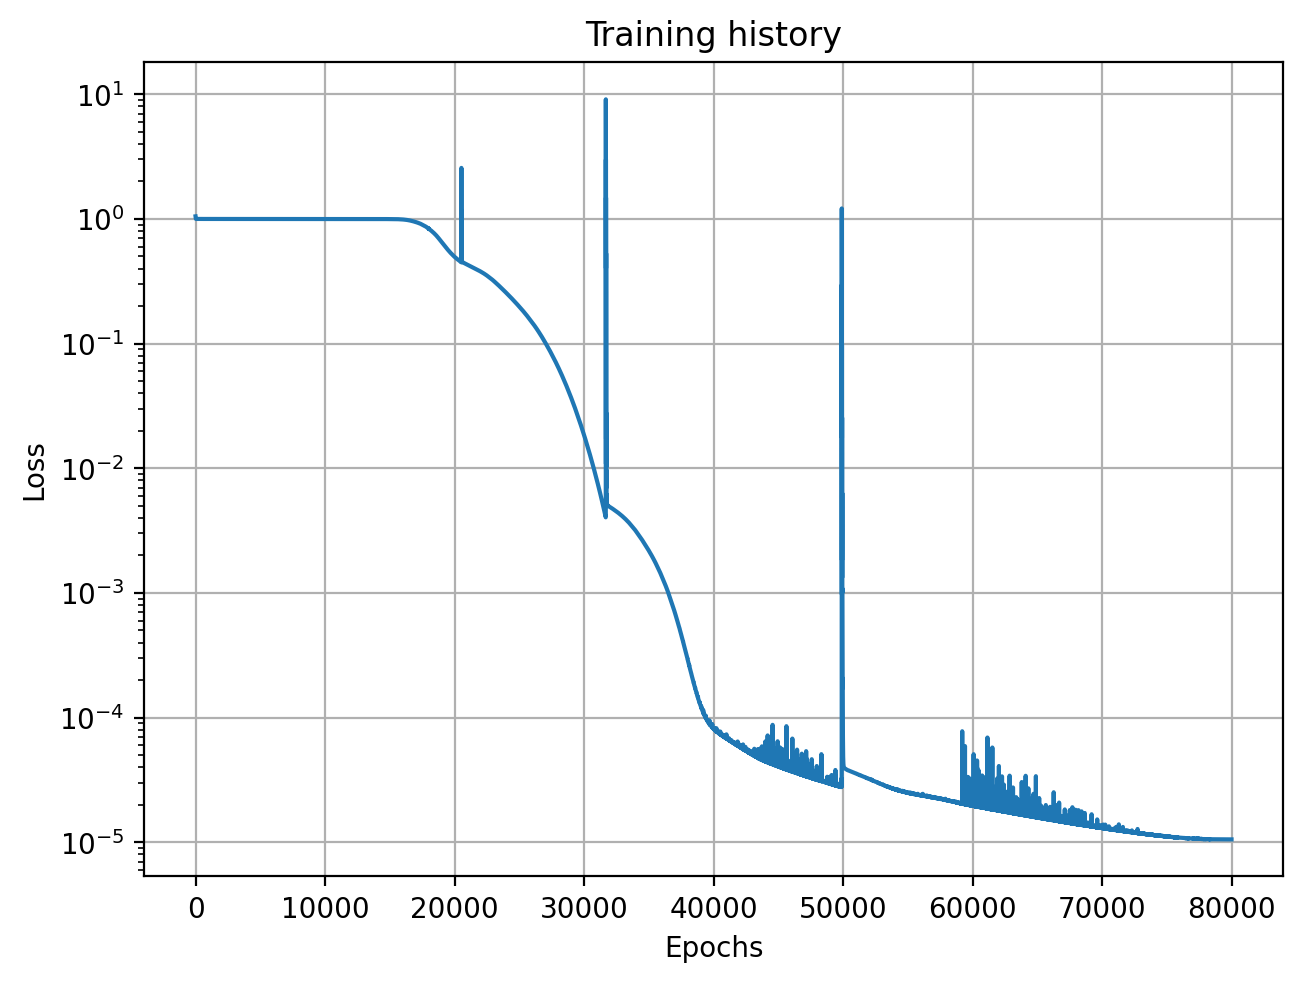

In [31]:
fig, ax = plt.subplots()
ax.semilogy(loss_history)
ax.set(xlabel="Epochs", ylabel="Loss", title="Training history")
ax.grid()
pass

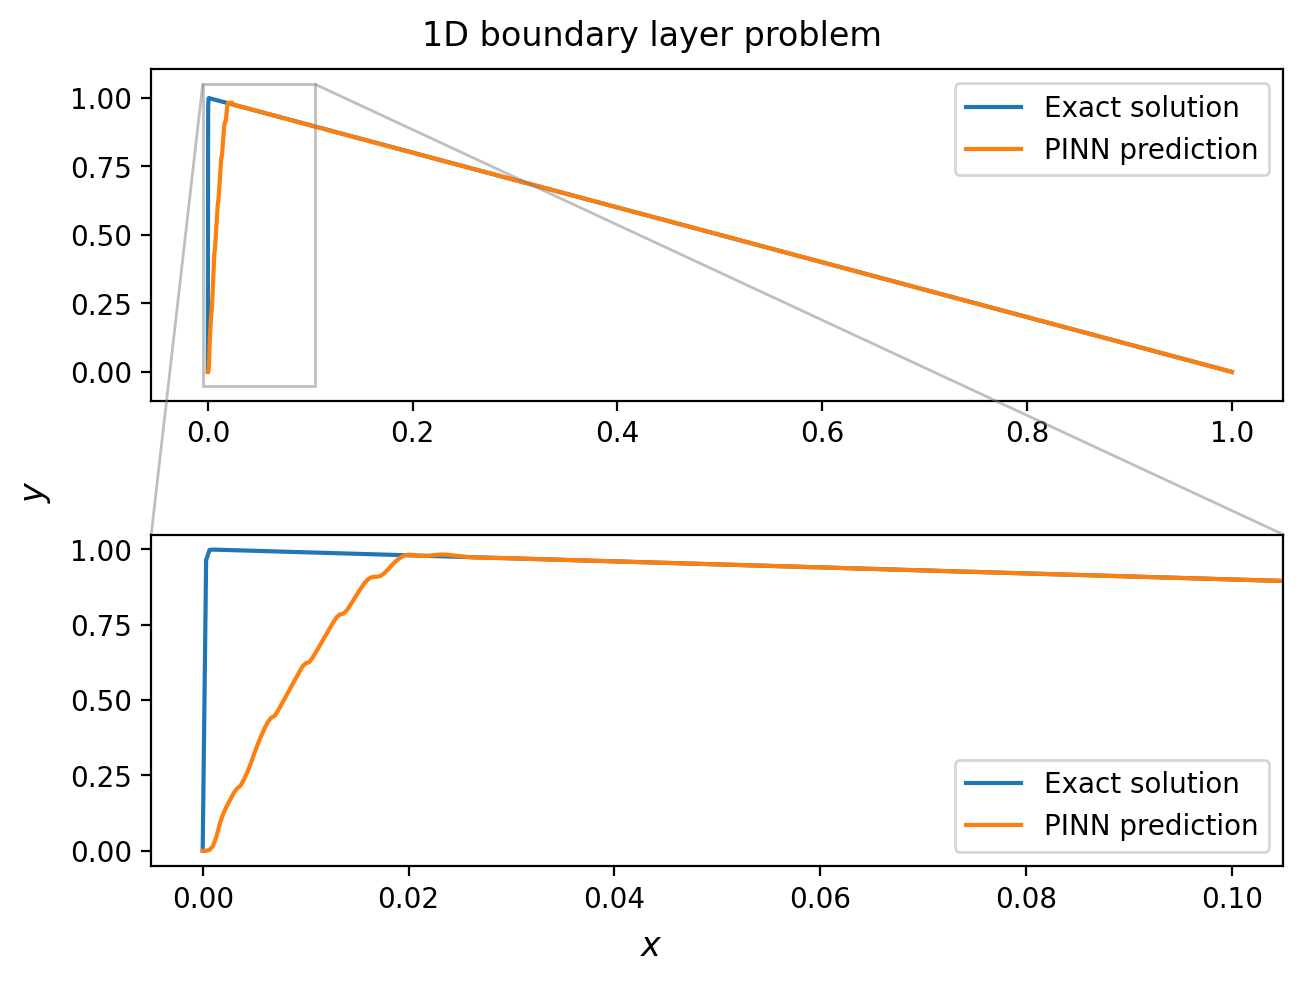

In [36]:
def boundary_layer_exact(x,eps):
  u=-x+(1-jnp.exp(-x/eps))/(1-jnp.exp(-1/eps))
  return u
# x_samples에 없던 값도 (내삽이 아니라 바로) 예측 가능
x_test=jnp.linspace(*domain, 10*n_x_samples)
u_pred=jax.vmap(boundary_layer_u, in_axes=(None,0))(params, x_test)
u_true=boundary_layer_exact(x_test,eps)
fig, (ax, ax_zoom) = plt.subplots(2,1)
ax.plot(x_test, u_true, label="Exact solution")
ax.plot(x_test, u_pred, label="PINN prediction")
ax.legend()
ax_zoom.plot(x_test, u_true, label="Exact solution")
ax_zoom.plot(x_test, u_pred, label="PINN prediction")
ax_zoom.set_xlim((-0.005,0.105))
ax_zoom.legend()
ax.indicate_inset_zoom(ax_zoom)
fig.supxlabel(R"$x$")
fig.supylabel(R"$y$")
fig.suptitle("1D boundary layer problem")
pass

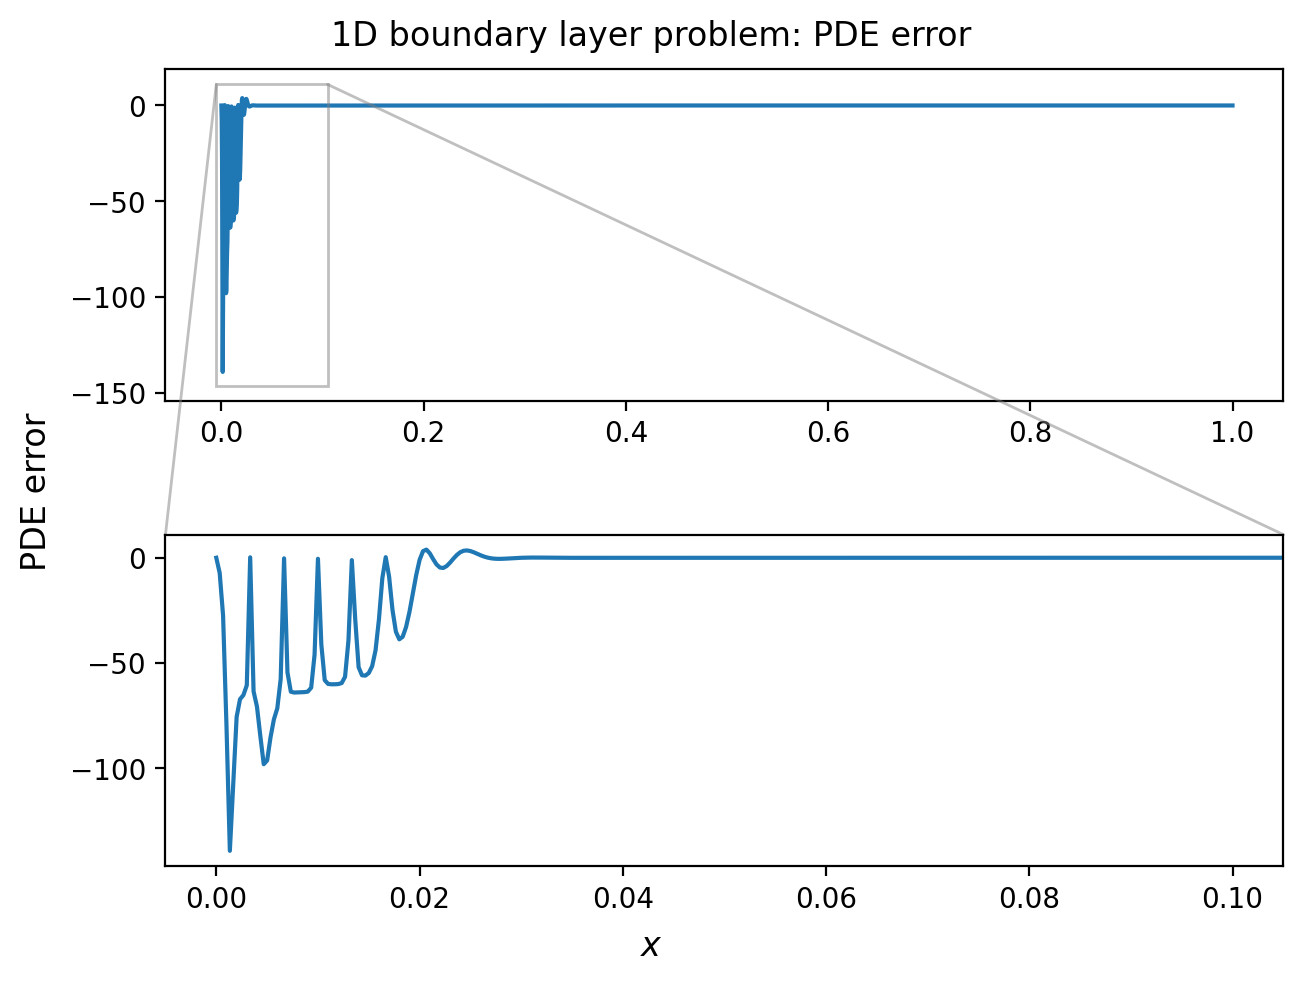

In [38]:
pde_test = batched_boundary_layer_pde(params, x_test)

fig, (ax, ax_zoom) = plt.subplots(2, 1)

ax.plot(x_test, pde_test)
ax_zoom.plot(x_test, pde_test)
ax_zoom.set_xlim((-0.005, 0.105))

ax.indicate_inset_zoom(ax_zoom)
fig.supxlabel(R"$x$")
fig.supylabel("PDE error")
fig.suptitle("1D boundary layer problem: PDE error")
pass

In [39]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable = jnp.tanh

    @nn.compact
    def __call__(self, x):
        for i, out_features in enumerate(self.features):
            x = nn.Dense(
                out_features, kernel_init=nn.initializers.lecun_normal()
            )(x) # dense에다가 out features 넣어주고, initial과 output 갯수를 넘겨줌
            if i < len(self.features) - 1:
                x = self.activation(x)
                # initial과 parameter를 넣지 않았는데, 자동으로 parameter와 initial을 넣어줌
        return x

In [40]:
model = MLP((5, 1))

key = jax.random.key(78)
params = model.init(key, jnp.zeros((2,)))

params

{'params': {'Dense_0': {'kernel': Array([[-0.03616341,  0.13113007,  0.53836703, -0.72711635,  0.22002998],
          [ 0.6621107 , -0.6484048 , -0.18050463, -1.3429725 ,  0.51266557]],      dtype=float32),
   'bias': Array([0., 0., 0., 0., 0.], dtype=float32)},
  'Dense_1': {'kernel': Array([[-0.503063  ],
          [-0.35913688],
          [ 0.0128446 ],
          [ 0.04773453],
          [ 0.30857202]], dtype=float32),
   'bias': Array([0.], dtype=float32)}}}

In [41]:
jax.tree.map(lambda x: x.shape, params)

{'params': {'Dense_0': {'bias': (5,), 'kernel': (2, 5)},
  'Dense_1': {'bias': (1,), 'kernel': (5, 1)}}}

In [42]:
x = jnp.array([1.5, 2.5])

y_pred = model.apply(params, x)
y_pred

Array([0.09768431], dtype=float32)

멀티 레이어 퍼셉트론

버거스 이퀘이션

In [47]:
# 문제와 모델 설정
domain_t = (0.0, 1.0)
domain_x = (-1.0, 1.0)

# ManualMLP로 바꿔도 똑같이 동작함
mlp = MLP((20, 20, 20, 20, 20, 20, 20, 20, 1))

def burger_boundary(t, x):
    # HACK: t = 0이거나, x = -1, 1 값만 들어온다고 가정
    return -jnp.sin(jnp.pi * x)

# (), () -> ()
def burger_u(params, t, x):
    return mlp.apply(params, jnp.array([t, x])).reshape()

# (N,), (N,) -> (N,)
batched_burger_u = jax.vmap(burger_u, in_axes=(None, 0, 0))

# (), () -> ()
def burger_pde(params, t, x):
    u_t = jax.jacfwd(burger_u, argnums=1) # t에 대한 미분
    u_x = jax.jacfwd(burger_u, argnums=2) # x에 대한 미분
    u_xx = jax.jacfwd(u_x, argnums=2) # u_x를 x에 대한 미분 한번 더

    return (
        u_t(params, t, x)
        + burger_u(params, t, x) * u_x(params, t, x)
        - 0.01 / jnp.pi * u_xx(params, t, x)
    )

# (N,), (N,) -> (N,)
batched_burger_pde = jax.vmap(burger_pde, in_axes=(None, 0, 0))

# (N_interior, 2), (N_boundary, 2) -> ()
def burger_loss(params, tx_interior, tx_boundary):
    physics_loss = (
        batched_burger_pde(params, tx_interior[:, 0], tx_interior[:, 1]) ** 2
    ).mean()
    boundary_loss = (
        (
            burger_boundary(tx_boundary[:, 0], tx_boundary[:, 1])
            - batched_burger_u(params, tx_boundary[:, 0], tx_boundary[:, 1])
        )
        ** 2
    ).mean()

    total_loss = physics_loss + boundary_loss

    return total_loss, (physics_loss, boundary_loss)

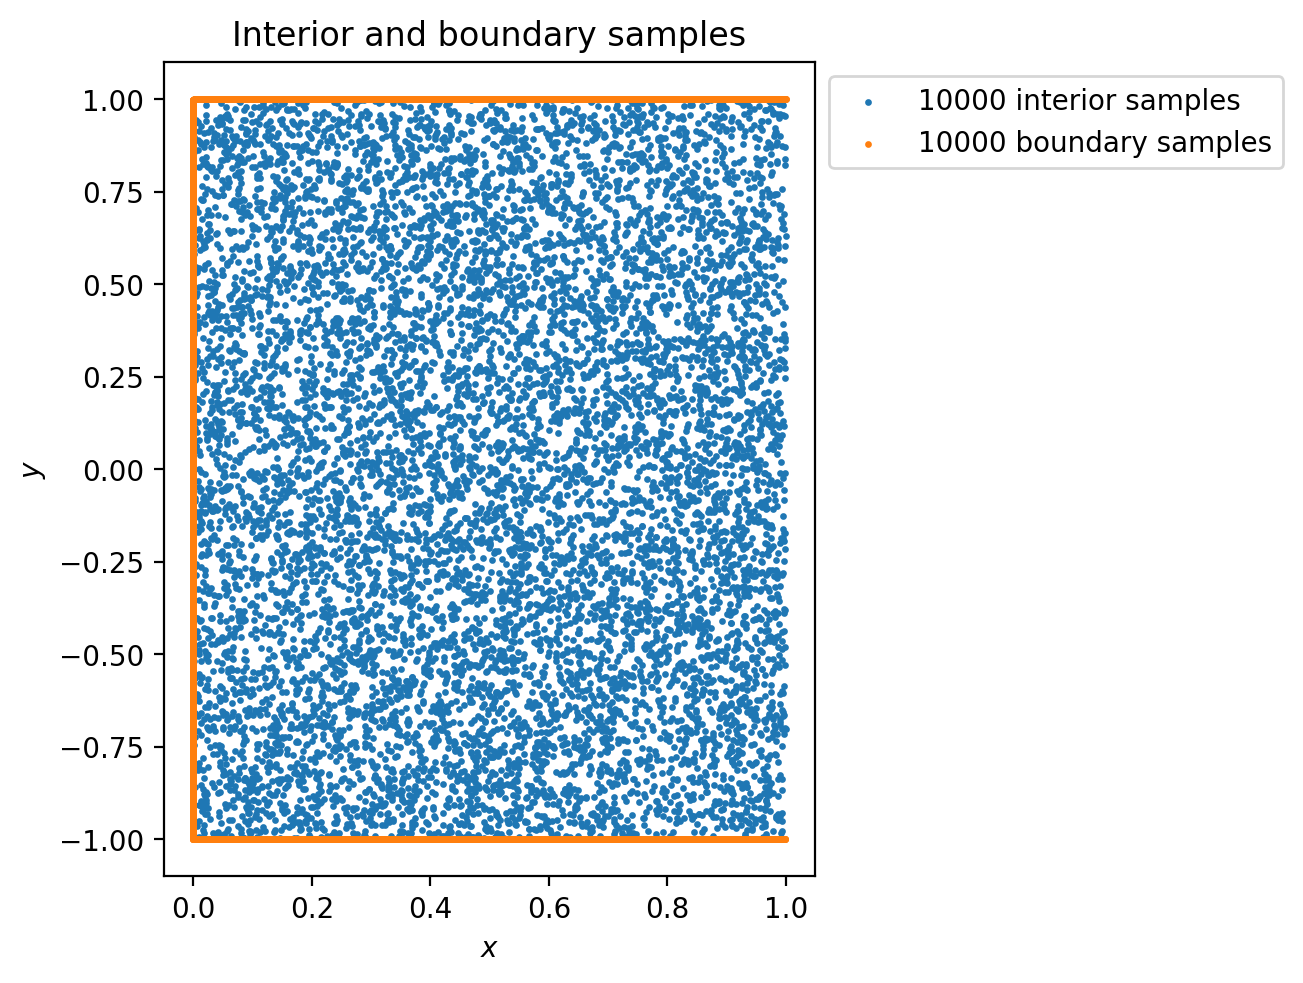

In [67]:
# 샘플링
@partial(jax.jit, static_argnums=(1,))
def sample_burger_interior(key, n_samples):
    t_key, x_key = jax.random.split(key)

    return jnp.column_stack([
        jax.random.uniform(
            t_key, shape=(n_samples,), minval=domain_t[0], maxval=domain_t[1]
        ),
        jax.random.uniform(
            x_key, shape=(n_samples,), minval=domain_x[0], maxval=domain_x[1]
        ),
    ])

@partial(jax.jit, static_argnums=(1,))
def sample_burger_boundary(key, n_samples):
    n_initial_samples = n_samples // 2
    n_boundary_samples = n_samples - n_initial_samples

    initial_key, boundary_t_key, boundary_x_key = jax.random.split(key, 3)

    x_initial = jax.random.uniform(
        initial_key,
        shape=(n_initial_samples,),
        minval=domain_x[0],
        maxval=domain_x[1],
    )
    initial_samples = jnp.column_stack([
        jnp.full_like(x_initial, domain_t[0]),
        x_initial,
    ])

    boundary_samples = jnp.column_stack([
        jax.random.uniform(
            boundary_t_key,
            shape=(n_boundary_samples,),
            minval=domain_t[0],
            maxval=domain_t[1],
        ),
        jax.random.choice(
            boundary_x_key, jnp.array(domain_x), shape=(n_boundary_samples,)
        ),
    ])

    return jnp.concatenate([initial_samples, boundary_samples])

interior_key, boundary_key = jax.random.split(jax.random.key(78))
tx_interior = sample_burger_interior(interior_key, n_samples=10000)
tx_boundary = sample_burger_boundary(interior_key, n_samples=10000)

fig, ax = plt.subplots()
ax.scatter(
    tx_interior[:, 0],
    tx_interior[:, 1],
    s=2,
    label=f"{tx_interior.shape[0]} interior samples",
)
ax.scatter(
    tx_boundary[:, 0],
    tx_boundary[:, 1],
    s=2,
    label=f"{tx_boundary.shape[0]} boundary samples",
)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set(xlabel=R"$x$", ylabel=R"$y$", title="Interior and boundary samples")
pass

In [71]:
# 훈련 설정
model_key, data_key = jax.random.split(jax.random.key(78))
n_epochs = 20_000
learning_rate = optax.cosine_decay_schedule(1e-3, decay_steps=n_epochs)
n_interior_samples = 10_000
n_boundary_samples = 100
optimizer = optax.adam(learning_rate)

params = mlp.init(model_key, jnp.zeros((2,)))
optimizer_state = optimizer.init(params)

@jax.jit
def step(params, optimizer_state, tx_interior, tx_boundary):
    loss, grads = jax.value_and_grad(burger_loss, has_aux=True)(
        params, tx_interior, tx_boundary
    )
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

In [72]:
loss_history = []
physics_loss_history = []
boundary_loss_history = []
for i in tqdm(range(1, n_epochs + 1)):
    # 매번 새로운 무작위 점을 샘플링
    data_key, interior_key, boundary_key = jax.random.split(data_key, 3)
    tx_interior = sample_burger_interior(interior_key, n_interior_samples)
    tx_boundary = sample_burger_boundary(boundary_key, n_boundary_samples)

    params, optimizer_state, (loss_value, (physics_loss, boundary_loss)) = step(
        params, optimizer_state, tx_interior, tx_boundary
    )
    loss_history.append(loss_value.item())
    physics_loss_history.append(physics_loss.item())
    boundary_loss_history.append(boundary_loss.item())
    if i % (n_epochs // 20) == 0:
        tqdm.write(f"Epoch {i}: {loss_value = :g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000: loss_value = 0.0468188
Epoch 2000: loss_value = 0.0130989
Epoch 3000: loss_value = 0.00896673
Epoch 4000: loss_value = 0.00594931
Epoch 5000: loss_value = 0.00248694
Epoch 6000: loss_value = 0.00353871
Epoch 7000: loss_value = 0.00143539
Epoch 8000: loss_value = 0.00179251
Epoch 9000: loss_value = 0.00113187
Epoch 10000: loss_value = 0.00113018
Epoch 11000: loss_value = 0.000644233
Epoch 12000: loss_value = 0.000837397
Epoch 13000: loss_value = 0.00128246
Epoch 14000: loss_value = 0.000478822
Epoch 15000: loss_value = 0.000504601
Epoch 16000: loss_value = 0.000358479
Epoch 17000: loss_value = 0.000461747
Epoch 18000: loss_value = 0.000319797
Epoch 19000: loss_value = 0.00038471
Epoch 20000: loss_value = 0.000381577


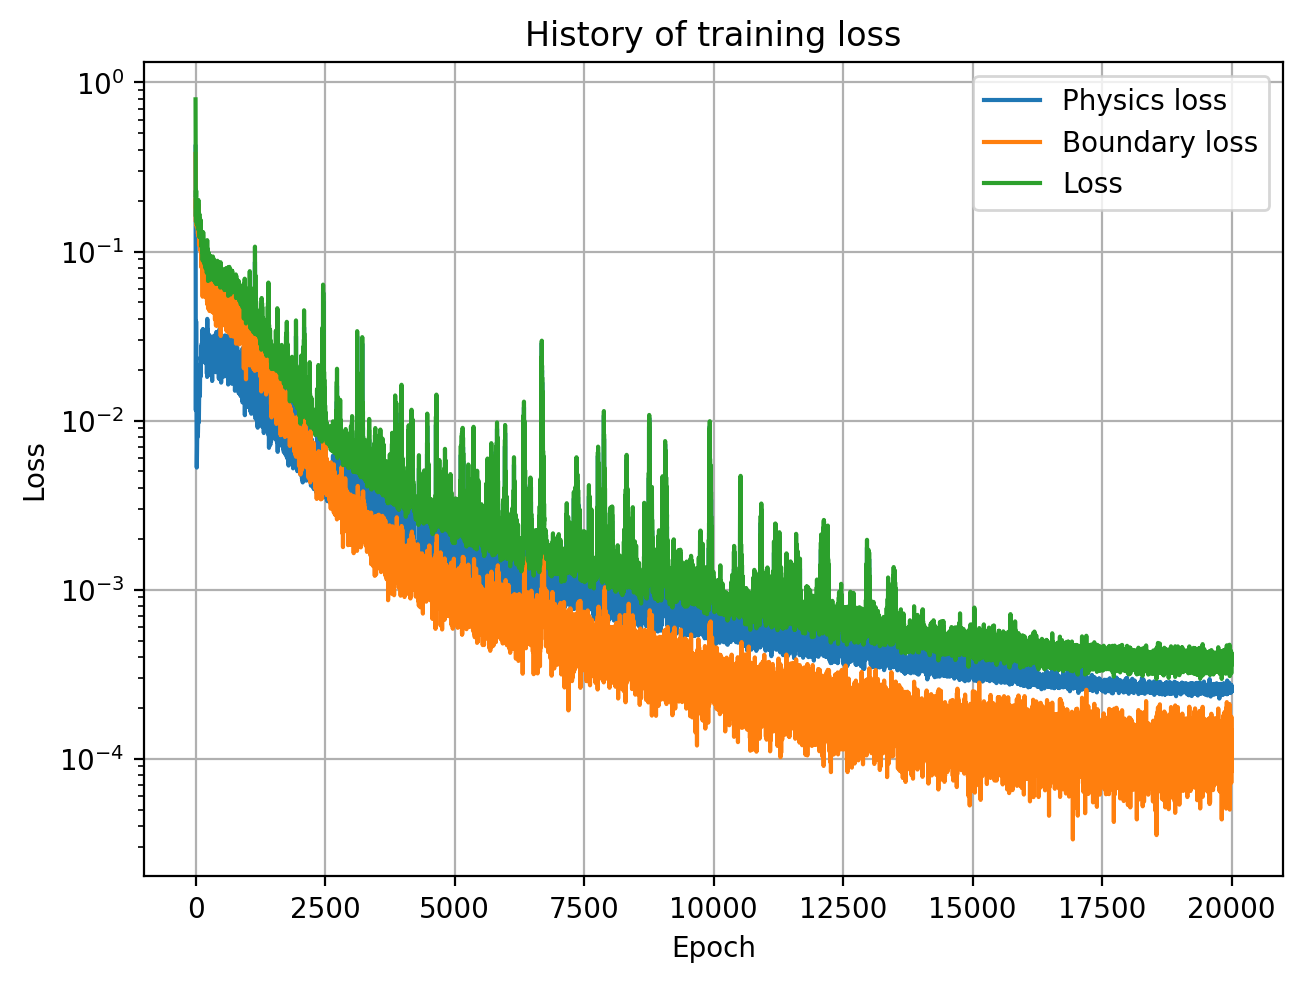

In [74]:
fig, ax = plt.subplots()
ax.semilogy(physics_loss_history, label="Physics loss")
ax.semilogy(boundary_loss_history, label="Boundary loss")
ax.semilogy(loss_history, label="Loss")
ax.set(
    xlabel="Epoch",
    ylabel="Loss",
    title="History of training loss",
)
ax.legend()
ax.grid()
pass

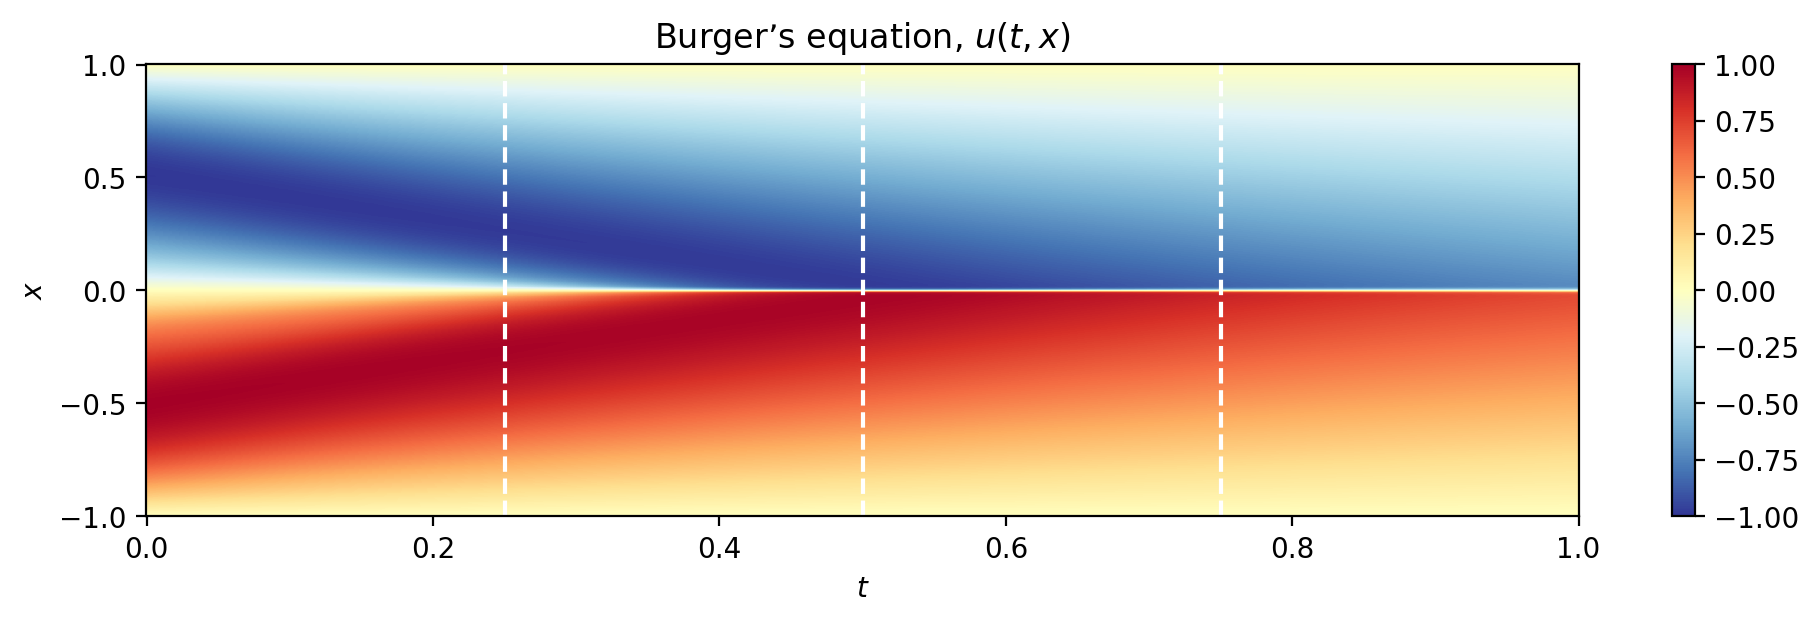

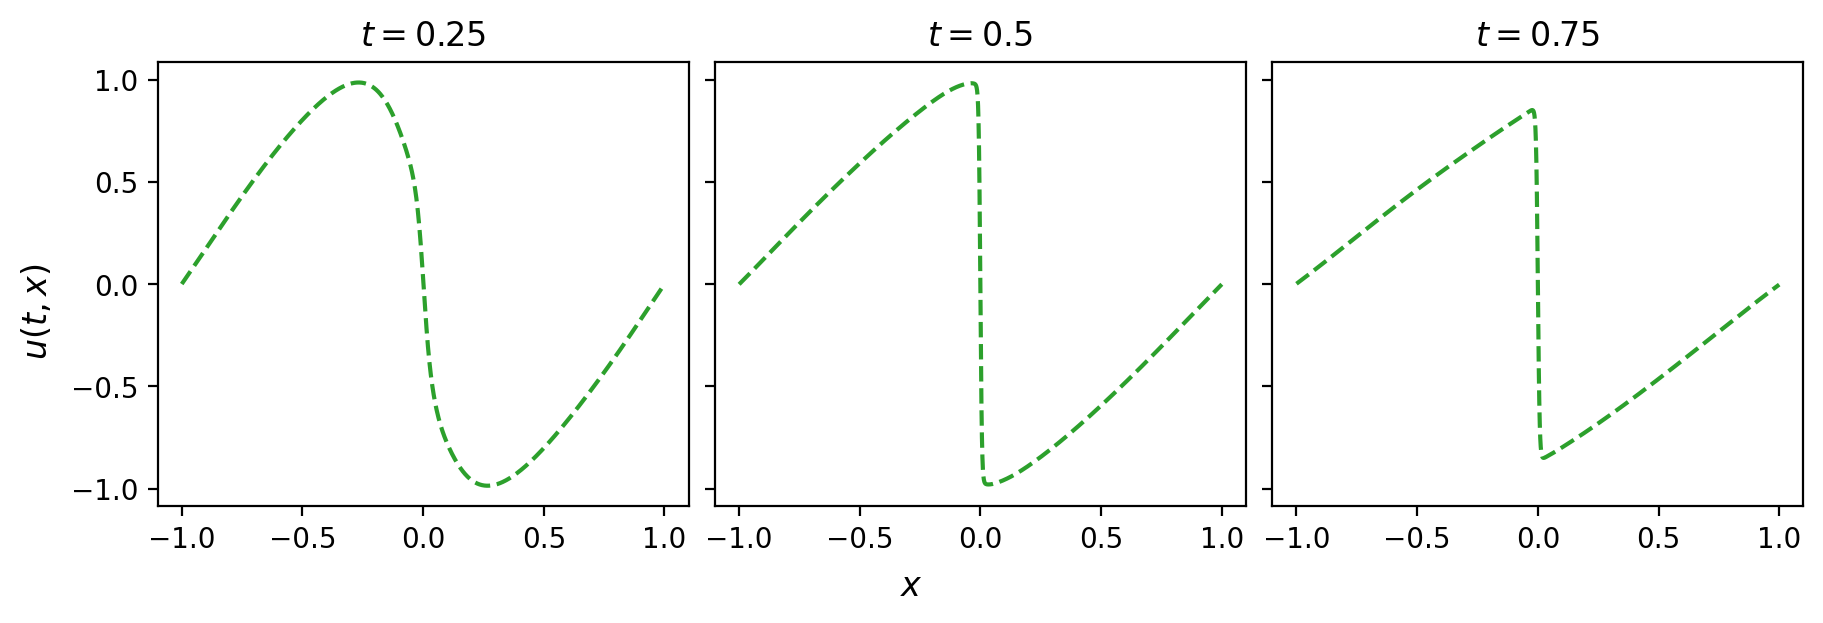

In [75]:
t_slices = [0.25, 0.5, 0.75]

t = jnp.linspace(*domain_t, 1001)
x = jnp.linspace(*domain_x, 1001)

T, X = jnp.meshgrid(t, x)

u = batched_burger_u(params, T.ravel(), X.ravel()).reshape(T.shape)

fig, ax = plt.subplots(figsize=(9, 3))
pcolormesh = ax.pcolormesh(T, X, u, vmin=-1, vmax=1, cmap="RdYlBu_r")
fig.colorbar(pcolormesh, ax=ax)
ax.set(xlabel=R"$t$", ylabel=R"$x$", title=R"Burger’s equation, $u(t, x)$")
for t_slice in t_slices:
    ax.axvline(t_slice, c="w", ls="--")

fig, axes = plt.subplots(
    1, len(t_slices), figsize=(9, 3), sharex=True, sharey=True
)
for t_slice, ax in zip(t_slices, axes.flat):
    u = batched_burger_u(params, jnp.full_like(x, t_slice), x)
    ax.plot(x, u, c="C2", ls="--")
    ax.set_title(Rf"$t = {t_slice}$")
fig.supxlabel(R"$x$")
fig.supylabel(R"$u(t, x)$")
pass